In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
'
FOLDERNAME = 'ML_Projects/CIFAR10'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/ML_Projects/CIFAR10/datasets
--2021-05-30 21:32:08--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  64.2MB/s    in 2.5s    

2021-05-30 21:32:11 (64.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


In [76]:
import torch
import torchvision

assert '.'.join(torch.__version__.split('.')[:2]) == '1.8'
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

In [11]:
NUM_TRAIN = 49000

In [12]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

In [13]:
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [31]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [44]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane truck  deer  bird


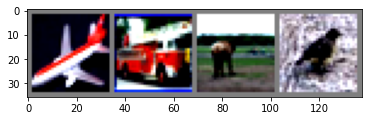

In [67]:
dataiter = iter(loader_train)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [58]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [71]:
def accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [72]:
def train(model, optimizer, epochs=1):
    model = model.to(device=device) 
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train() 
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [74]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

In [99]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [100]:
channel_1 = 16
channel_2 = 32
channel_3 = 64
channel_4 = 128
num_classes = 10

conv1 = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=3, padding=1),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
)

conv2 = nn.Sequential(
    nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.MaxPool2d(2)
)

conv3 = nn.Sequential(
    nn.Conv2d(channel_2, channel_3, kernel_size=3, padding=1),
    nn.BatchNorm2d(channel_3),
    nn.ReLU(),
    nn.MaxPool2d(2)
)

conv4 = nn.Sequential(
    nn.Conv2d(channel_3, channel_4, kernel_size=3, padding=1),
    nn.BatchNorm2d(channel_4),
    nn.ReLU(),
    nn.MaxPool2d(2)
)

fc =  nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(128*4*4, num_classes)
)

model = nn.Sequential(
    conv1,
    conv2,
    conv3,
    conv4,
    Flatten(),
    fc
)

learning_rate = 1e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print_every = 10000

train(model, optimizer, epochs=10)

Iteration 0, loss = 2.5669
Checking accuracy on validation set
Got 140 / 1000 correct (14.00)

Iteration 0, loss = 1.1270
Checking accuracy on validation set
Got 639 / 1000 correct (63.90)

Iteration 0, loss = 0.7232
Checking accuracy on validation set
Got 729 / 1000 correct (72.90)

Iteration 0, loss = 0.5440
Checking accuracy on validation set
Got 775 / 1000 correct (77.50)

Iteration 0, loss = 0.4702
Checking accuracy on validation set
Got 768 / 1000 correct (76.80)

Iteration 0, loss = 0.3899
Checking accuracy on validation set
Got 790 / 1000 correct (79.00)

Iteration 0, loss = 0.5240
Checking accuracy on validation set
Got 792 / 1000 correct (79.20)

Iteration 0, loss = 0.5772
Checking accuracy on validation set
Got 796 / 1000 correct (79.60)

Iteration 0, loss = 0.4689
Checking accuracy on validation set
Got 812 / 1000 correct (81.20)

Iteration 0, loss = 0.2301
Checking accuracy on validation set
Got 814 / 1000 correct (81.40)

